In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_1d_distribution, kl_estimate_with_mc
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
def p_ak_given_traj_and_z(aux_traj, z_samples, auxiliary_vars, total_var):

    b_k = torch.sum(aux_traj)
    s_k_minus_one = total_var - torch.sum(auxiliary_vars[:-1])
    s_k = s_k_minus_one - auxiliary_vars[-1]

    mean_scalar = auxiliary_vars[-1] / s_k_minus_one
    variance = auxiliary_vars[-1] * s_k / s_k_minus_one

    mean = (z_samples - b_k) * mean_scalar

    return mean, variance

def gmm_mixing_weights(aux_traj_log_probs):
    """Takes p(a_k | a_{1:k-1}, z_i) for each z_i and computes the GMM mixing weights"""
    return torch.softmax(aux_traj_log_probs, dim=0)

def q_ak_given_traj(component_means, component_vars, mixing_weights):
    
    mixing_categorical = dist.categorical.Categorical(probs=mixing_weights)
    
    component_gaussians = dist.normal.Normal(loc=component_means, scale=torch.sqrt(component_vars))
    
    gmm = dist.mixture_same_family.MixtureSameFamily(mixing_categorical, component_gaussians)
    
    return gmm

The KL between q and p is 13.201 nats.


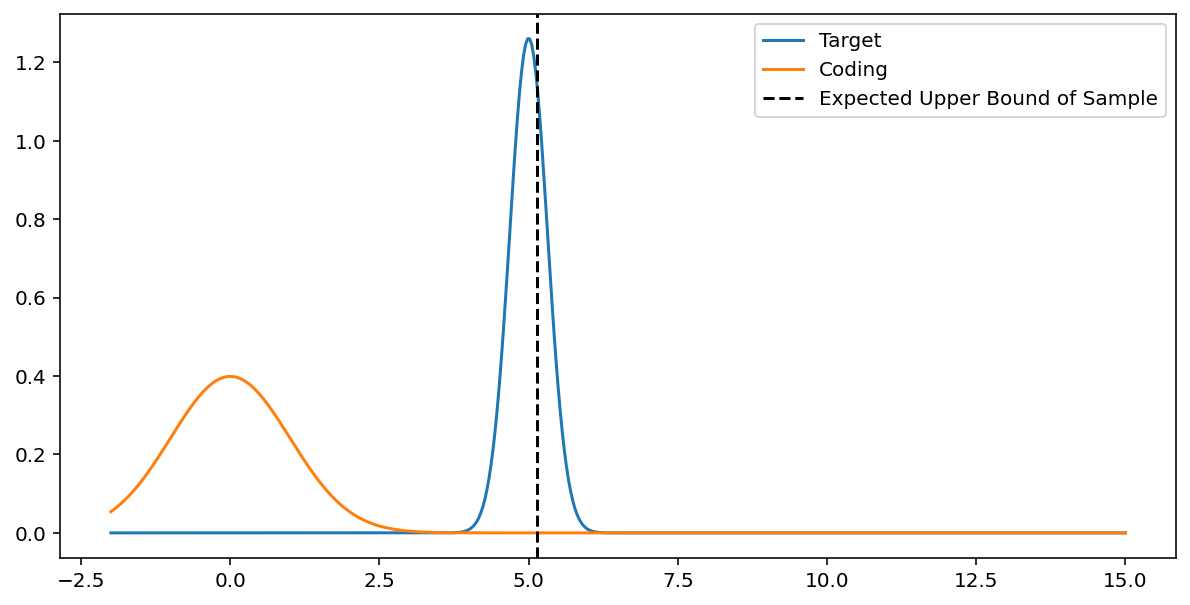

In [772]:
torch.manual_seed(100)

q_loc = 5
q_var = .1

p_loc = 0.
p_var = 1.

# q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
# comp_q = dist.normal.Normal(loc=torch.tensor([10., 100.]), scale = math.pow(q_var, 0.5))
# mix_q = dist.categorical.Categorical(probs=torch.tensor([0.25, 0.75]))
# q = dist.MixtureSameFamily(mix_q, comp_q)
q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = math.pow(p_var, 0.5))

z_sample = q.sample()

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=100000)
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-2., q_loc + 10, 500)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')

# expected upper bound
ub = np.sqrt(p_var) * torch.sqrt(total_kl*(1+0.) * 2)

ax.axvline(ub, c='k', ls='--', label='Expected Upper Bound of Sample')

ax.legend()

plt.show()

In [773]:
from scipy.stats import gamma, chi2, norm
import scipy

# Implementing the scheme

In [872]:
omega = 5.
epsilon = 0.02
num_empirical_samples = 1
num_aux = math.ceil(total_kl / omega)
num_aux = 1
#num_samples_per_aux = math.ceil(math.exp(omega * (1. + epsilon)))
num_samples_per_aux = math.ceil(math.exp(total_kl * (1+epsilon)))
print(f"The KL is {total_kl:.3f}, Omega: {omega:.0f} and epsilon is: {epsilon}."
      f"\nSo num auxiliaries: {num_aux} and num samples per aux: {num_samples_per_aux}.")

The KL is 13.201, Omega: 5 and epsilon is: 0.02.
So num auxiliaries: 1 and num samples per aux: 704553.


In [873]:
1 - chi2(1).cdf(q_loc**2 / p_var) ** math.ceil(math.exp(total_kl * (1+epsilon)))

0.33230417811660584

In [874]:
1 - chi2(1).cdf(q_loc**2 / (p_var * num_aux)) ** num_samples_per_aux

0.33230417811660584

In [875]:
NormalRV = norm(loc=p_loc, scale=p_var ** 0.5)
delta = q_var ** 0.5

In [876]:
M = math.ceil(math.exp(total_kl * (1+epsilon)))

In [877]:
1 - (np.exp(M * scipy.special.logsumexp(np.array([NormalRV.logcdf(-(q_loc+delta)), NormalRV.logcdf(q_loc-delta)],  dtype=np.float64))))

0.6151271488861456

In [878]:
1 - (NormalRV.cdf(-(q_loc+delta)) + NormalRV.cdf(q_loc-delta)) ** M

0.6151271488596667

## Can we guarantee the scheme will work?

For 1D the problem is simply, we need to reach the mode. What does this entail?

First we can say that to reach the mode, defined as $D$, when sampling from aux priors with 0 mean and variance $\sigma_k^2 = 1/K$ where $K$ is the number of auxiliary variables given by $\lceil\operatorname{KL}(q||p)\hspace{3pt} / \hspace{3pt} \Omega\rceil$, that on-average we need each aux var to take value $\pm D / K$, here the plus-minus refers to which sign of the mode.



In [879]:
def upper_bound_rudimentary_coding_check(kl, mode, omega):
    """
    Checks whether the scheme will work. If it doens't work, compute the necessary epsilon to make things work.
    """
    
    num_samples = math.ceil(torch.exp(torch.tensor(omega)))
    average_target_deviation = math.pow(math.ceil(kl / omega), 0.5)
    
    necessary_samples = 1. / dist.normal.Normal(loc=0., scale=1).cdf(-mode / average_target_deviation)
    
    if num_samples > necessary_samples:
        return None
    else:
        epsilon = torch.log(torch.ceil(necessary_samples)) / omega - 1
        return epsilon


In [880]:
def upper_bound_max_mean_std_normal(n):
    pi = torch.tensor(np.pi)
    e = torch.tensor(np.e)
    euler_mascheroni = torch.tensor(np.euler_gamma)
    return torch.sqrt(torch.log(n ** 2/ (2 * pi * torch.log(n ** 2 / (2 * pi))))) * (1 + euler_mascheroni / torch.log(n))

def upper_bound_expected_value(num_aux, num_samples_per_aux):
    mean_max_std_normals = upper_bound_max_mean_std_normal(num_samples_per_aux)
    return mean_max_std_normals * (num_aux ** 0.5)

def lower_bound_rudimentary_check(kl, mode, omega):
    n = nn.Parameter(torch.tensor(float(math.ceil(math.exp(omega)))))
    n_aux = math.ceil(kl / omega)
    pi = torch.tensor(np.pi)
    e = torch.tensor(np.e)
    euler_mascheroni = torch.tensor(np.euler_gamma)
    expected_distance = upper_bound_expected_value(n_aux, n.detach())
    
    if expected_distance > mode:
        print(f"The coding scheme may work.")
        return None
    else:
        optim = torch.optim.Adam([n], lr=1.)
        loss = 10
        while loss > 1e-10:
            optim.zero_grad()
            expected_distance = upper_bound_expected_value(n_aux, n)
            loss = 0.5 * (mode - expected_distance) ** 2
            loss.backward()
            optim.step()
        necessary_epsilon = torch.log(n.detach()) / omega - 1
        return necessary_epsilon

In [881]:
def rough_epsilon_bounds(kl, mode, omega):
    epsilon_lb, epsilon_ub = lower_bound_rudimentary_check(kl, mode, omega), upper_bound_rudimentary_coding_check(kl, mode, omega)
    
    if (epsilon_lb is None) and (epsilon_ub is None):
        print(f'The Coding Scheme should work!')
    elif epsilon_lb is None:
        print(f"May need epsilon as large as: {epsilon_ub}.")
    else:
        print(f"Scheme should work with epsilon between: [{epsilon_lb:.3f}, {epsilon_ub:.3f}].")
    return epsilon_lb, epsilon_ub

In [882]:
def p_all_samples_reach(kl, mode, omega):
    n_aux = math.ceil(kl / omega)
    num_samples = math.ceil(torch.exp(torch.tensor(omega)))
    print(dist.normal.Normal(loc=0., scale=1).cdf(mode * num_aux ** 0.5))
    return 1 - dist.normal.Normal(loc=0., scale=1).cdf(mode * num_aux ** 0.5) ** num_samples

In [883]:
def bound_expected_max(kl, mode, omega, epsilon=0.):
    n_aux = math.ceil(kl / omega)
    n = torch.tensor(math.ceil(torch.exp(torch.tensor(omega * (1 + epsilon)))))
    pi = torch.tensor(np.pi)
    lb = 1./torch.sqrt(pi * torch.log(torch.tensor(2))) * (n_aux ** -0.5) * torch.sqrt(torch.log(n))
    ub = torch.sqrt(torch.log(n)) * (2 ** 0.5) * (n_aux ** -0.5)
    return lb, ub

In [884]:
e_lb, e_ub = bound_expected_max(total_kl, z_sample, omega, epsilon=0.47)

In [885]:
e_lb * num_aux, e_ub * num_aux

(tensor(1.0607), tensor(2.2137))

In [886]:
from tqdm.notebook import tqdm

In [893]:
auxiliary_vars = p_var * torch.ones(num_aux) / num_aux
total_var = p_var

z_samples = q.sample((num_empirical_samples,))
pbar = trange(1, num_aux + 1)
greedy_samples = []
is_samples = []
biggest_samples = []

for seed in tqdm(torch.randint(low=0, high=int(1e10), size=(1000,))):
    torch.manual_seed(seed)
    aux_traj_greedy = torch.zeros([0])
    aux_traj_log_q_greedy = torch.zeros(1)
    aux_traj_log_p_greedy = torch.zeros(1)
    aux_traj_is = torch.zeros([0])
    aux_traj_log_q_is = torch.zeros(1)
    aux_traj_log_p_is = torch.zeros(1)
    biggest_sample = torch.zeros(1)
    for i in pbar:
        aux_traj_mixing_weights_greedy = torch.ones((num_empirical_samples,))
        aux_traj_mixing_weights_is = torch.ones((num_empirical_samples,))
        #
        if i < num_aux:
            # first compute the prior
            aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[i-1], 0.5))

            # compute the posterior
            mixing_weights_greedy = gmm_mixing_weights(aux_traj_mixing_weights_greedy)
            means_greedy, variances_greedy = p_ak_given_traj_and_z(aux_traj_greedy, z_samples, auxiliary_vars[:i], total_var)
            aux_post_greedy = q_ak_given_traj(means_greedy, variances_greedy, mixing_weights_greedy)
            
            mixing_weights_is = gmm_mixing_weights(aux_traj_mixing_weights_is)
            means_is, variances_is = p_ak_given_traj_and_z(aux_traj_is, z_samples, auxiliary_vars[:i], total_var)
            aux_post_is = q_ak_given_traj(means_is, variances_is, mixing_weights_is)


            # sample trial aks
            trial_samples = aux_prior.sample((num_samples_per_aux,))
            
            # choose biggest
            biggest_sample += torch.max(trial_samples)
            
            #GREEDY
            # compute log probabilities under prior and posterior
            log_p = aux_prior.log_prob(trial_samples)
            log_q_greedy = aux_post_greedy.log_prob(trial_samples)

            # compute the joint probability of the full trajectories
            log_p_joint_greedy = log_p + aux_traj_log_p_greedy 
            log_q_joint_greedy = log_q_greedy + aux_traj_log_q_greedy

            # compute log importance sampling weight log(q/p)
            log_importance_sampling_weight_greedy = log_q_joint_greedy - log_p_joint_greedy

            # greedily choose the best weight
            best_sample_idx_greedy = torch.argmax(log_importance_sampling_weight_greedy)
            
            # compute the corresponding sample
            best_sample_greedy = trial_samples[best_sample_idx_greedy]

            # append to trajectory
            aux_traj_greedy = torch.cat([aux_traj_greedy, best_sample_greedy[None]])
            aux_traj_log_p_greedy += log_p[best_sample_idx_greedy]
            aux_traj_log_q_greedy += log_q_greedy[best_sample_idx_greedy]

            # compute the new mixing weights by adding new component densities to old joint component densities
            aux_traj_mixing_weights_greedy += aux_post_greedy.component_distribution.log_prob(best_sample_greedy)
            
            #IMPORTANCE SAMPLING
            # compute log probabilities under prior and posterior
            log_p = aux_prior.log_prob(trial_samples)
            log_q_is = aux_post_is.log_prob(trial_samples)

            # compute the joint probability of the full trajectories
            log_p_joint_is = log_p + aux_traj_log_p_is
            log_q_joint_is = log_q_is + aux_traj_log_q_is

            # compute log importance sampling weight log(q/p)
            log_importance_sampling_weight_is = log_q_joint_is - log_p_joint_is
            # create categorical over weights
            cat = dist.Categorical(probs=torch.exp(log_importance_sampling_weight_is))
            is_idx = cat.sample()
            
            # compute corresponding sample
            best_sample_is = trial_samples[is_idx]
            
            # append to trajectory
            aux_traj_is = torch.cat([aux_traj_is, best_sample_is[None]])
            aux_traj_log_p_is += log_p[is_idx]
            aux_traj_log_q_is += log_q_is[is_idx]

            # compute the new mixing weights by adding new component densities to old joint component densities
            aux_traj_mixing_weights_is += aux_post_is.component_distribution.log_prob(best_sample_is)


        else:
            # last sample we complete the sum and choose best sample under q

            # first compute the prior
            aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[-1], 0.5))

            # sample trial aKs
            trial_samples = aux_prior.sample((num_samples_per_aux,))
            biggest_sample += torch.max(trial_samples)


            # GREEDY
            # complete the sum
            final_trial_zs_greedy = torch.sum(aux_traj_greedy, dim=0) + trial_samples
            
            # compute log q
            log_q_greedy = q.log_prob(final_trial_zs_greedy)
            
            # compute log p
            log_p_greedy = p.log_prob(final_trial_zs_greedy)

            # choose best sample
            best_sample_idx_greedy = torch.argmax(log_q_greedy - log_p_greedy)
            best_sample_greedy = trial_samples[best_sample_idx_greedy]
            aux_traj_greedy = torch.cat([aux_traj_greedy, best_sample_greedy[None]])
            
            # IMPORTANCE SAMPLING
            # complete the sum
            final_trial_zs_is = torch.sum(aux_traj_is, dim=0) + trial_samples
            
            # compute log q
            log_q_is = q.log_prob(final_trial_zs_is)
            
            # compute log p
            log_p_is = p.log_prob(final_trial_zs_is)
            # make categorical dist
            cat = dist.Categorical(probs=torch.exp(log_q_is - log_p_is))
            is_idx = cat.sample()
            
            is_chosen_sample = trial_samples[is_idx]
            aux_traj_is = torch.cat([aux_traj_is, is_chosen_sample[None]])

    greedy_samples.append(torch.sum(aux_traj_greedy))
    is_samples.append(torch.sum(aux_traj_is))
    biggest_samples.append(biggest_sample)

        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [894]:
torch.sum(torch.tensor(biggest_samples) >= q_loc) / len(biggest_samples)

tensor(0.1700)

In [895]:
torch.sum(torch.abs(torch.tensor(greedy_samples) - q_loc) <= delta) / len(greedy_samples)

tensor(0.5910)

In [896]:
torch.sum(torch.abs(torch.tensor(is_samples) - q_loc) <= delta) / len(is_samples)

tensor(0.4750)

<ipython-input-946-e8a236f45eba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axis.scatter(samples[i], torch.exp(q.log_prob(torch.tensor(samples[i]))), alpha=1, color='red', marker='X')
<ipython-input-946-e8a236f45eba>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axis.text(11, 1.0, 'Bias: ' + r'$\log\frac{q(\mathbf{z})}{p(\mathbf{z})}=$' + f'{(q.log_prob(torch.tensor(samples[i])) - p.log_prob(torch.tensor(samples[i]))).mean():.2f}\n'
<ipython-input-946-e8a236f45eba>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  + 'Variance: '

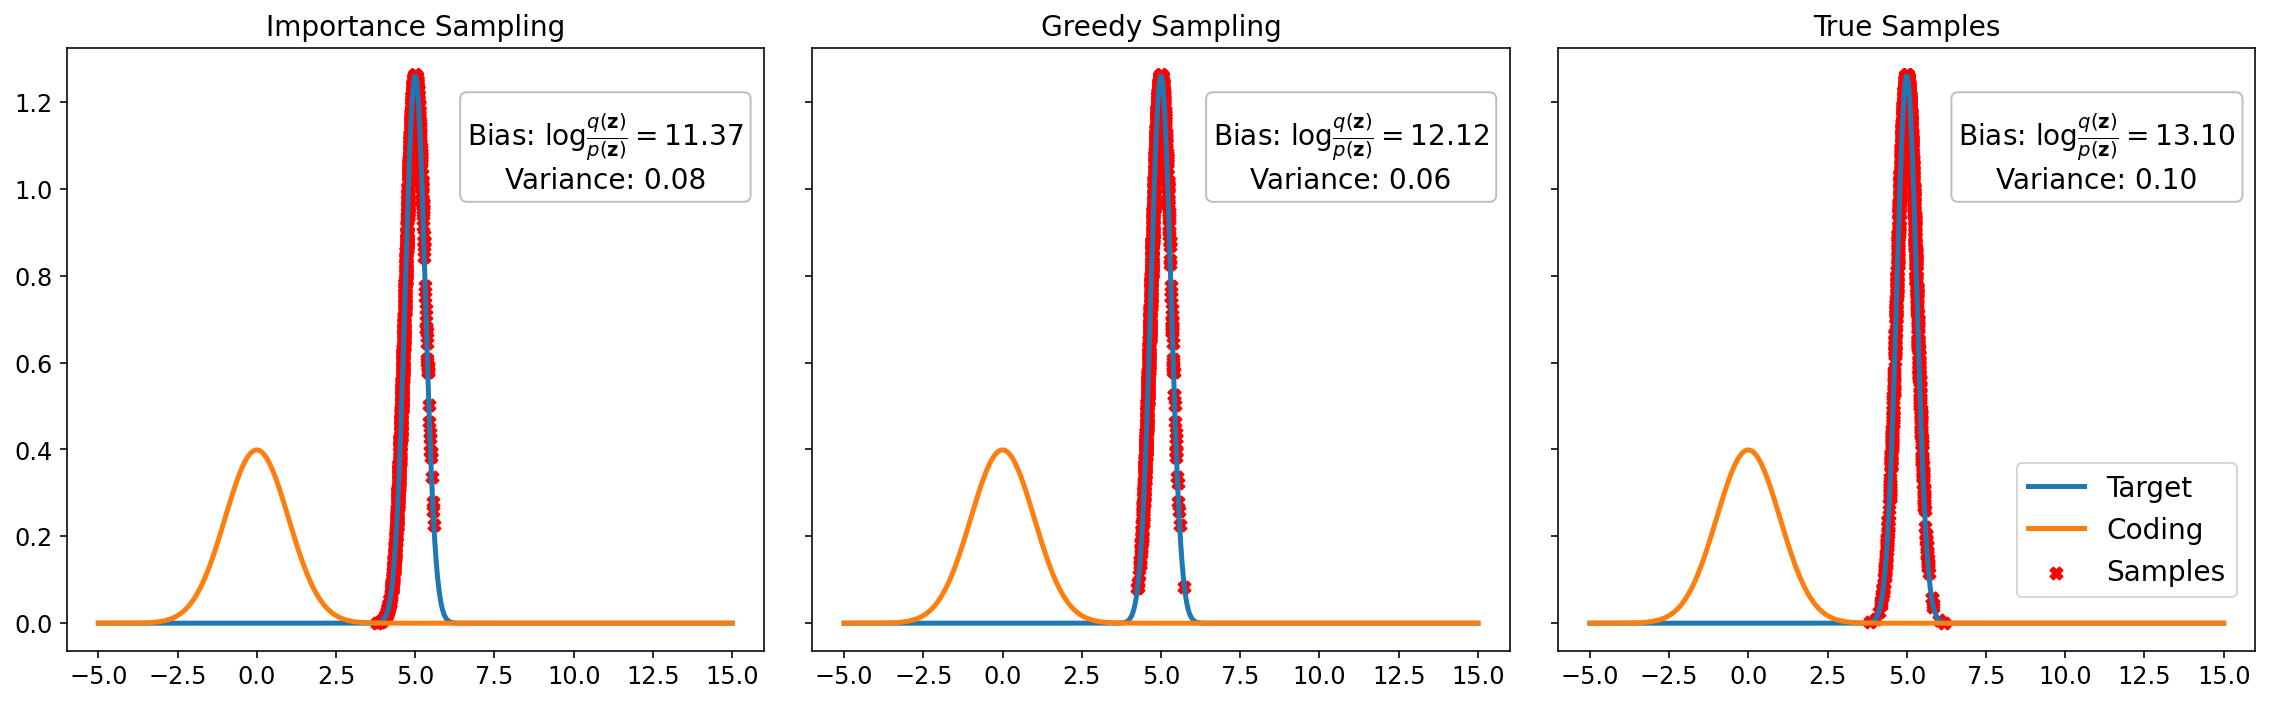

In [946]:
samples = [is_samples, greedy_samples, q.sample((len(greedy_samples),)).clone()]
titles = ['Importance Sampling', 'Greedy Sampling', 'True Samples']
f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 5))
xs = torch.linspace(-5., q_loc + 10, 500)
fs=14
for i, axis in enumerate(ax):
    axis.scatter(samples[i], torch.exp(q.log_prob(torch.tensor(samples[i]))), alpha=1, color='red', marker='X')
    axis.plot(xs, torch.exp(q.log_prob(xs)), linewidth=2.5)
    axis.plot(xs, torch.exp(p.log_prob(xs)), linewidth=2.5)
    axis.set_title(titles[i], fontsize=fs)
    axis.tick_params(axis='both', which='major', labelsize=fs-2)
    axis.tick_params(axis='both', which='minor', labelsize=fs-2)

    bbox = {'facecolor': 'white', 'alpha': 0.25, 'pad': 0.25, 'boxstyle': 'round', 'edgecolor':'black'}
    axis.text(11, 1.0, 'Bias: ' + r'$\log\frac{q(\mathbf{z})}{p(\mathbf{z})}=$' + f'{(q.log_prob(torch.tensor(samples[i])) - p.log_prob(torch.tensor(samples[i]))).mean():.2f}\n' 
              + 'Variance: ' + f'{torch.tensor(samples[i]).var():.2f}' ,
             bbox=bbox, horizontalalignment='center', fontsize=fs)
f.tight_layout()
f.legend(['Target', 'Coding', 'Samples'], loc = (0.8875, 0.15), ncol=1, fontsize=fs)

In [949]:
np.exp(20)

485165195.4097903